# Initial Setup

In [188]:
import os
import sys
from typing import List,Optional, Dict, Any, Tuple
import pandas as pd
import numpy as np
# import matplotlib as plt
import matplotlib.pyplot as plt

# llama index imports
import llama_index.core
from llama_index.core import SimpleDirectoryReader,VectorStoreIndex,SummaryIndex, StorageContext, Settings, load_index_from_storage, Response
from llama_index.vector_stores.chroma import ChromaVectorStore
from llama_index.core.node_parser import SentenceSplitter, CodeSplitter, LangchainNodeParser
from llama_index.core.tools import FunctionTool,QueryEngineTool
from llama_index.core.vector_stores import MetadataFilters,FilterCondition
from llama_index.core.objects import ObjectIndex
from llama_index.readers.file import IPYNBReader, PandasCSVReader
from llama_index.experimental.query_engine import PandasQueryEngine
from llama_index.experimental.query_engine.pandas import (
    PandasInstructionParser,
)
from llama_index.core.prompts import PromptTemplate
from llama_index.core.query_pipeline import (
    QueryPipeline as QP,
    Link,
    InputComponent,
    AgentFnComponent,
    AgentInputComponent,
    CustomQueryComponent,
    FnComponent,
    RouterComponent,
)
from llama_index.experimental.query_engine import PandasQueryEngine
from llama_index.readers.file import IPYNBReader, PandasCSVReader
from llama_index.experimental.query_engine import PandasQueryEngine
from llama_index.experimental.query_engine.pandas import (
    PandasInstructionParser,
)

from llama_index.core.callbacks import CallbackManager

# llama index agent imports
from llama_index.core.agent import FunctionCallingAgentWorker, ReActAgent, Task, AgentChatResponse, AgentRunner, QueryPipelineAgentWorker

# llama index llms and embeddings imports
from llama_index.llms.mistralai import MistralAI
from llama_index.llms.openai import OpenAI
from llama_index.llms.ollama import Ollama
from llama_index.embeddings.mistralai import MistralAIEmbedding
from llama_index.embeddings.fastembed import FastEmbedEmbedding
from llama_index.embeddings.ollama import OllamaEmbedding
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

# custom package imports
from llama_index.packs.tables.chain_of_table.base import ChainOfTableQueryEngine, serialize_table

# langchain imports
from langchain.text_splitter import RecursiveCharacterTextSplitter, Language

# uncertainty imports
from crepes import WrapClassifier, ConformalClassifier
from venn_abers import VennAbersCalibrator, VennAbers

# tools
import nest_asyncio # to allow running async functions in jupyter
import chromadb # persistent storage for vectors
# import nbconvert
import tree_sitter
import tree_sitter_languages
import phoenix as px
from pyvis.network import Network

## Global Variables

In [198]:
temperture = 0.0 #for deterministic results

llm_model = "mistral-large-latest"
# llm_model = "codestral-latest"
MISTRAL_API_KEY =  "BWdlihu9sUh5P2g3bHnzjAaHiT4anTVH"
os.environ["MISTRAL_API_KEY"] = MISTRAL_API_KEY
llm = MistralAI(model=llm_model, temperature=temperture)

# llm_model = "gpt-3.5-turbo"
# # llm_model = "gpt-4"
# OPENAI_API_KEY =  "something"
# os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
# llm = OpenAI(model=llm_model, temperature=temperture)

# llm_model = "codellama"
# llm = Ollama(model=llm_model, request_timeout=1200.0, base_url="http://localhost:11434", temperature=temperture)

nest_asyncio.apply() # to allow running async functions in jupyter
px.launch_app()
llama_index.core.set_global_handler("arize_phoenix")
net = Network(notebook=True, cdn_resources="in_line", directed=True)

WARNI [phoenix.session.session] Existing running Phoenix instance detected! Shutting it down and starting a new instance...


🌍 To view the Phoenix app in your browser, visit http://localhost:6006/
📖 For more information on how to use Phoenix, check out https://docs.arize.com/phoenix


# Implementation

## Load Data



In [53]:
# loading file
file_path = "./data_csv/Sepsis_Processed_IC.csv"
df = pd.read_csv(file_path)

## Query Pipeline Setup

In [96]:
instruction_str = (
    "1. Convert the query to executable Python code using Pandas.\n"
    "2. The final line of code should be a Python expression that can be called with the `eval()` function.\n"
    "3. The code should represent a solution to the query.\n"
    "4. PRINT ONLY THE EXPRESSION.\n"
    "5. Do not quote the expression.\n"
    "6. Add axis labels, legend, and title when creating a plot.\n"
)

pandas_prompt_str = (
    "You are working with a pandas dataframe in Python.\n"
    "The name of the dataframe is `df`. You should interpret the columns of the dataframe as follows: \n"
    "1) Each row represents patient data related to sepsis diagnosis.\n"
    "2) The Target column indicates whether the patient had sepsis.\n"
    "3) The duration_since_reg column describes the patient's stay after admission in days.\n"
    "4) Diagnosis-related columns detail specific diagnostic results and associated codes.\n"
    "5) The dataset includes patient demographics age, clinical measurements (crp, lacticacid, leucocytes), and diagnostic procedures (diagnosticartastrup, diagnosticblood, etc.).\n"
    "6) The dataframe also records clinical criteria for sepsis (sirscritheartrate, sirscritleucos, etc.), resource usage, and event transitions (e.g., CRP => ER Triage).\n"
    "7) Additional columns capture organ dysfunction, hypotension, hypoxia, suspected infection, and treatment details like infusions and oliguria.\n"
    "8) The dataset covers the transitions between various clinical events, highlighting the pathways in the patient's diagnostic and treatment journey.\n"
    "9) ER here refers to the emergency room.\n"
    "10) You only answer questions related to the dataframe.\n"
    "11) If you do not know the answer, then say you do not know.\n\n"

    "This is the result of `print(df.head())`:\n"
    "{df_str}\n\n"
    
    "Follow these instructions:\n"
    "{instruction_str}\n"
    "Query: {query_str}\n\n"
    "Expression:"
)
response_synthesis_prompt_str = (
    "Given an input question, synthesize a response from the query results.\n"
    "Query: {query_str}\n\n"
    "Pandas Instructions (optional):\n{pandas_instructions}\n\n"
    "Pandas Output: {pandas_output}\n\n"
    "Response: "
)

code_execution = (
    "Execute the code to generate the output and include explanation.\n"
    "Query: {query_str}\n\n"
    "Pandas Output: {pandas_output}\n\n"
    "Response: "
)


class CustomPandasInstructionParser(PandasInstructionParser):
    def parse(self, text):
        # Prepend the necessary import statements
        imports = "import pandas as pd\nimport matplotlib.pyplot as plt\n"
        # Combine the imports with the code generated by the model
        code = imports + text
        return code


pandas_prompt = PromptTemplate(pandas_prompt_str).partial_format(
    instruction_str=instruction_str, df_str=df.head(5)
)

pandas_output_parser = PandasInstructionParser(df)
# pandas_output_parser = CustomPandasInstructionParser(df)
response_synthesis_prompt = PromptTemplate(response_synthesis_prompt_str)
code_execution_prompt = PromptTemplate(code_execution)



In [97]:
# define query pipeline with modules
qp_table = QP(
    modules={
        "input": InputComponent(),
        "pandas_prompt": pandas_prompt,
        "llm1": llm,
        "pandas_output_parser": pandas_output_parser,
        "response_synthesis_prompt": response_synthesis_prompt,
        "llm2": llm,
        "code_execution": code_execution_prompt,
        "llm3": llm,
    },
    verbose=True,
)

qp_table.add_chain(["input", "pandas_prompt", "llm1", "pandas_output_parser"])
qp_table.add_links(
    [
        Link("input", "response_synthesis_prompt", dest_key="query_str"),
        Link(
            "llm1", "response_synthesis_prompt", dest_key="pandas_instructions"
        ),
        Link(
            "pandas_output_parser",
            "response_synthesis_prompt",
            dest_key="pandas_output",
        ),
    ]
)

qp_table.add_link("response_synthesis_prompt", "llm2")

qp_table.add_links(
    [
        Link("input", "code_execution", dest_key="query_str"),
        Link(
            "pandas_output_parser",
            "code_execution",
            dest_key="pandas_output",
        ),
    ]
)

qp_table.add_link("code_execution", "llm3")

In [6]:
# create diagram of the query pipeline
net.from_nx(qp_table.clean_dag)
net.show("qp_table.html")

qp_table.html


## Query Pipeline run

In [6]:
# run query
response = qp_table.run(
    query_str="how many positive cases?",
)

> Running module input with input: 
query_str: how many positive cases?

> Running module pandas_prompt with input: 
query_str: how many positive cases?

> Running module llm1 with input: 
messages: You are working with a pandas dataframe in Python.
The name of the dataframe is `df`. You should interpret the columns of the dataframe as follows: 
 1) Each row represents patient data related to sep...

> Running module pandas_output_parser with input: 
input: assistant: df['Target'].sum()

> Running module response_synthesis_prompt with input: 
query_str: how many positive cases?
pandas_instructions: assistant: df['Target'].sum()
pandas_output: 98

> Running module llm2 with input: 
messages: Given an input question, synthesize a response from the query results.
Query: how many positive cases?

Pandas Instructions (optional):
df['Target'].sum()

Pandas Output: 98

Response: 



In [11]:
# query result
print(response.message.content)

Based on the data provided, there are 98 positive cases.


In [12]:
# run query
response = qp_table.run(
    query_str="what is the average time patients spend in the hospital?",
)
# query result
print("final response: ================================================================================================================================================================================================")
print(response.message.content)

> Running module input with input: 
query_str: what is the average time patients spend in the hospital?

> Running module pandas_prompt with input: 
query_str: what is the average time patients spend in the hospital?

> Running module llm1 with input: 
messages: You are working with a pandas dataframe in Python.
The name of the dataframe is `df`.
This is the result of `print(df.head())`:
  case_id  Target  age  max_activity_count  duration_since_reg  crp  \
0...

> Running module pandas_output_parser with input: 
input: assistant: df['duration_since_reg'].mean()

> Running module response_synthesis_prompt with input: 
query_str: what is the average time patients spend in the hospital?
pandas_instructions: assistant: df['duration_since_reg'].mean()
pandas_output: 11.568710217755443

> Running module llm2 with input: 
messages: Given an input question, synthesize a response from the query results.
Query: what is the average time patients spend in the hospital?

Pandas Instructions (optio

> Running module input with input: 
query_str: visualize the age distribution?

> Running module pandas_prompt with input: 
query_str: visualize the age distribution?

> Running module llm1 with input: 
messages: You are working with a pandas dataframe in Python.
The name of the dataframe is `df`. You should interpret the columns of the dataframe as follows: 
1) Each row represents patient data related to seps...

> Running module pandas_output_parser with input: 
input: assistant: df['age'].plot(kind='hist', bins=20, color='skyblue', edgecolor='black', title='Age Distribution', xlabel='Age', ylabel='Frequency')

> Running module response_synthesis_prompt with input: 
query_str: visualize the age distribution?
pandas_instructions: assistant: df['age'].plot(kind='hist', bins=20, color='skyblue', edgecolor='black', title='Age Distribution', xlabel='Age', ylabel='Frequency')
pandas_output: Axes(0.125,0.11;0.775x0.77)

> Running module code_execution with input: 
query_str: visualize the a

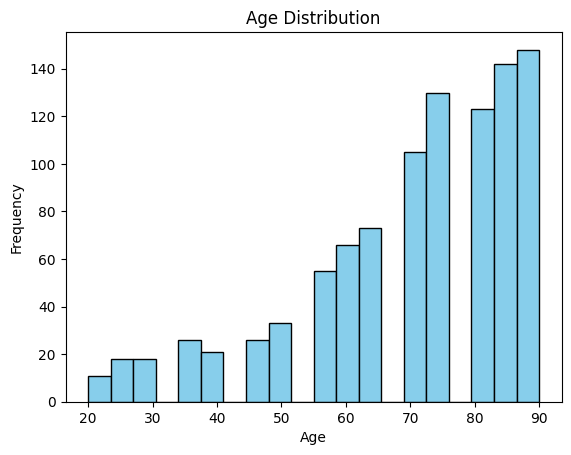

In [98]:
# run query
response = qp_table.run(
    query_str="visualize the age distribution?",
)
# query result
print("final response: ================================================================================================================================================================================================")
print(response.message.content)

## Model Evaluation Agent Setup

In [196]:
# evaluate model
def evaluate_model(model_name:str, threshold:int = -1) -> dict:
    """Load the trained model, evaluation data and evaluate the loaded model."""
    from sklearn.metrics import roc_auc_score, roc_auc_score, average_precision_score, confusion_matrix, f1_score, matthews_corrcoef
    from joblib import load
    
    model_save_path = 'models'
    model = load(f'./{model_save_path}/{model_name}.joblib')
    X_test = pd.read_csv('./data_python/Sepsis_X_test.csv')
    y_test = pd.read_csv('./data_python/Sepsis_y_test.csv')

    pred_prob = model.predict_proba(X_test) # get the prediction probabilities for the test set
    predictions = model.predict(X_test) # get the predictions for the test set

    roc_auc = roc_auc_score(y_test, pred_prob[:,1]) # calculate the roc auc score
    average_precision = average_precision_score(y_test, pred_prob[:,1]) # calculate the
    best_threshold = model.best_threshold_

    if threshold > 0:
        predictions = np.where(pred_prob[:,1] > threshold, 1, 0)
        mcc = matthews_corrcoef(y_test, predictions)
        f1_macro = f1_score(y_test, predictions, average='macro')
        cm = confusion_matrix(y_test, predictions)

    else:
        mcc =  matthews_corrcoef(y_test, predictions)
        f1_macro = f1_score(y_test, predictions, average='macro')
        cm = confusion_matrix(y_test, predictions)

    return {"roc_auc":roc_auc, "average_precision":average_precision, "mcc":mcc, "f1_macro":f1_macro, "confusion_matrix":cm, "best_threshold":best_threshold}

# uncertainty quantification
def conformal_prediction(model_name:str, alpha:int = -1) -> dict:
    """Load the trained model, do uncertainty quantification on the loaded model and return the coverage and average width of the prediction sets."""
    from joblib import load
    from crepes import WrapClassifier
    
    """ loading the model and data"""
    model_save_path = 'models'
    model = load(f'./{model_save_path}/{model_name}.joblib')
    X_cal = pd.read_csv('./data_python/Sepsis_X_cal.csv')
    y_cal = pd.read_csv('./data_python/Sepsis_y_cal.csv').to_numpy().reshape(-1)
    X_test = pd.read_csv('./data_python/Sepsis_X_test.csv')
    y_test = pd.read_csv('./data_python/Sepsis_y_test.csv').to_numpy().reshape(-1)

    """calibrating the model"""
    wrapped_clf = WrapClassifier(model) 
    wrapped_clf.calibrate(X_cal, y_cal)
    
    """ uncertainty quantification - coverage and average width of the prediction sets"""
    if alpha > 0:
        prediction_sets = wrapped_clf.predict_set(X_test, confidence=(1-alpha))
        coverage = np.mean([prediction_sets[i][y_test[i]] for i in range(len(prediction_sets))])
        widths = [np.sum(pred) for pred in prediction_sets] 
        average_width = np.mean(widths)
    else:
        alpha = 0.1
        prediction_sets = wrapped_clf.predict_set(X_test, confidence=(1-alpha))
        coverage = np.mean([prediction_sets[i][y_test[i]] for i in range(len(prediction_sets))])
        widths = [np.sum(pred) for pred in prediction_sets] 
        average_width = np.mean(widths)
    
    return {"coverage":coverage, "average_width":average_width}

# venn abers
def venn_abers_calibration(model_name:str) -> dict:
    """ Load the trained model, do uncertainty quantification using Venn-Abers calibration and generate the prediction intervals for the test set."""

    # load the trained model
    from venn_abers import VennAbersCalibrator, VennAbers
    from joblib import load

    model_save_path = 'models'
    plot_save_path = 'plots'

    va = VennAbersCalibrator() # initialize the Venn-Abers calibrator

    # load the model and data
    model = load(f'./{model_save_path}/{model_name}.joblib')
    X_cal = pd.read_csv('./data_python/Sepsis_X_cal.csv')
    y_cal = pd.read_csv('./data_python/Sepsis_y_cal.csv').to_numpy().reshape(-1)
    X_test = pd.read_csv('./data_python/Sepsis_X_test.csv')
    y_test = pd.read_csv('./data_python/Sepsis_y_test.csv').to_numpy().reshape(-1)

    # model results
    prediction_prob_cal = model.predict_proba(X_cal)
    prediction_prob_test = model.predict_proba(X_test)

    # get calibrated prediction probabilities and predicted class labels
    p_prime = va.predict_proba(p_cal=prediction_prob_cal, y_cal=y_cal, p_test=prediction_prob_test, p0_p1_output=True) # probability intervals for class 1
    y_pred = np.argmax(va.predict(p_cal=prediction_prob_cal, y_cal=y_cal, p_test=prediction_prob_test), axis=1) # predicted class labels

    # get the prediction probabilities and intervals for class 1
    y_pred_interval_p1 = p_prime[1] # intervals for class 1
    y_pred_p1 = p_prime[0][:, 1] # predicted probability of class 1

    # create dataframe using the prediction probabilities and intervals for class 1
    df = pd.DataFrame({'p0': y_pred_interval_p1[:,0], 'p1': y_pred_interval_p1[:,1], 'p of class_1': y_pred_p1, 'y': y_test})
    display(df.head(10))


    # sort the predictions based on the predicted probability of class 1
    sorted_indices = np.argsort(y_pred_p1) # sort the predicted probabilities of class 1
    y_pred_interval_p1 = y_pred_interval_p1[sorted_indices]
    y_pred_p1 = y_pred_p1[sorted_indices]
    y_test_sorted = y_test[sorted_indices]
    y_pred_sorted = y_pred[sorted_indices]

    # calculate the lower and upper bounds of the intervals for class 1
    lower_bound = y_pred_p1 - y_pred_interval_p1[:, 0] # calculate lower bound by subtracting the lower interval from the predicted probability of class 1
    upper_bound = y_pred_interval_p1[:, 1] - y_pred_p1 # calculate upper bound by subtracting the predicted probability of class 1 from the upper interval 
    bounds = [lower_bound, upper_bound]

    # plot the predicted probability of class 1 with intervals
    plt.figure(figsize=(8, 5))
    plt.errorbar(np.arange(len(y_pred_p1)), y_pred_p1, yerr=bounds, fmt='o', ecolor='tab:red', capsize=5, label='Predicted Probability of Class 1')
    # plt.scatter(np.arange(len(y_pred_p1)), y_test_sorted, color='tab:blue', label='Actual Label')
    plt.axhline(y=0.5, color='black', linestyle='--', linewidth=1)
    plt.ylabel('Probability')
    plt.xlabel('Test Sample')
    plt.title('Predicted Probability of Class 1 with intervals')
    plt.savefig(f'./{plot_save_path}/prediction_intervals.png')
    plt.close()

    return {"plot_path":f'./{plot_save_path}/prediction_intervals.png'}

# create tools
evaluate_model_tool = FunctionTool.from_defaults(name="evaluate_model", fn=evaluate_model)
conformal_prediction_tool = FunctionTool.from_defaults(name="conformal_prediction", fn=conformal_prediction)
venn_abers_calibration_tool = FunctionTool.from_defaults(name="venn_abers_calibration", fn=venn_abers_calibration)
tools = [conformal_prediction_tool, evaluate_model_tool, venn_abers_calibration_tool]

top_level_agent_prompt = """
                You are designed to help with a variety of tasks, from answering questions \
                to providing summaries to other types of analyses.

                ## Tools
                You have access to a wide variety of tools. You are responsible for using
                the tools in any sequence you deem appropriate to complete the task at hand.
                This may require breaking the task into subtasks and using different tools
                to complete each subtask.

                You have access to the following tools:
                {tool_desc}

                ## Output Format
                To answer the question, please use the following format.

                ```
                Thought: I need to use a tool to help me answer the question.
                Action: tool name (one of {tool_names}) if using a tool.
                Action Input: the input to the tool, in a JSON format representing the kwargs (e.g. {{"input": "hello world", "num_beams": 5}})
                ```

                Please ALWAYS start with a Thought.

                Please use a valid JSON format for the Action Input. Do NOT do this {{'input': 'hello world', 'num_beams': 5}}.

                If this format is used, the user will respond in the following format:

                ```
                Observation: tool response
                ```

                You should keep repeating the above format until you have enough information
                to answer the question without using any more tools. At that point, you MUST respond
                in the one of the following two formats:

                ```
                Thought: I can answer without using any more tools.
                Answer: [your answer here]
                ```

                ```
                Thought: I cannot answer the question with the provided tools.
                Answer: Sorry, I cannot answer your query.
                ```

                ## Additional Rules
                - You MUST obey the function signature of each tool. Do NOT pass in no arguments if the function expects arguments.
                - For queries that require uncertainty quantification (like 'what is the coverage and average width of the prediction sets'), use 'conformal_prediction'.
                - For queries that requires to evaluate the model (like 'what is the f1 score of the model'), use 'evaluate_model'.
                - For queries that require Venn-Abers calibration (like 'generate the prediction intervals for the test set'), use 'venn_abers_calibration'.
                - Answer only the questions asked.

                ## Current Conversation
                Below is the current conversation consisting of interleaving human and assistant messages.
                """
model_agent_prompt = PromptTemplate(top_level_agent_prompt)
agent_model = ReActAgent.from_tools(tools=tools, 
                                     llm=llm,
                                     verbose=True)
agent_model.update_prompts({"agent_worker:system_prompt": model_agent_prompt})

## Model Evaluation Agent run

In [197]:
# response = await agent.achat("what is the auc_roc score of the trained model?")
# response = agent_model.query("what is the auc_roc score of the XGBoost model?")
# response = agent_model.query("what is the uncertainty quantification of the HGBoost model?")
response = agent_model.query("what is the prediction intervals for XGBoost model?")
print(str(response))

Thought: I need to use a tool to help me answer the question.
Action: venn_abers_calibration
Action Input: {'model_name': 'XGBoost'}


,p0,p1,p of class_1,y
0,0.142857,0.190476,0.181818,0
1,0.047619,0.142857,0.130435,0
2,0.000000,0.034483,0.033333,0
3,0.017544,0.035088,0.034483,0
4,0.750000,1.000000,0.800000,1
5,0.017544,0.063830,0.061006,0
6,0.017544,0.040000,0.039121,0
7,0.000000,0.027778,0.027027,0
8,0.017544,0.035714,0.035077,0
9,0.017544,0.050000,0.048428,0


Observation: {'plot_path': './plots/prediction_intervals.png'}
Thought: I can answer without using any more tools.
Answer: The prediction intervals for the XGBoost model have been generated and saved in a plot. You can find the plot at the following path: './plots/prediction_intervals.png'.
The prediction intervals for the XGBoost model have been generated and saved in a plot. You can find the plot at the following path: './plots/prediction_intervals.png'.


## Multi Agent Setup

In [15]:
# methods for running the agents / query pipelines
def run_agent(query: str) -> str:
    """Run the agent model on the query to get evaluation results from trained model."""
    response = agent_model.query(query)
    return str(response)

def run_query_pipeline(query: str) -> str:
    """Run the query pipeline to analyze dataset for the given query."""
    response = qp_table.run(
        query_str=query,
    )
    return str(response.message.content)

# create tools
run_agent_tool = FunctionTool.from_defaults(name="run_agent", fn=run_agent)
run_query_pipeline_tool = FunctionTool.from_defaults(name="run_query_pipeline", fn=run_query_pipeline)
agent_tools = [run_agent_tool, run_query_pipeline_tool]

top_level_agent_prompt = """
                You are designed to help with a variety of tasks, from answering questions \
                to providing summaries to other types of analyses.

                ## Tools
                You have access to a wide variety of tools. You are responsible for using
                the tools in any sequence you deem appropriate to complete the task at hand.
                This may require breaking the task into subtasks and using different tools
                to complete each subtask.

                You have access to the following tools:
                {tool_desc}

                ## Output Format
                To answer the question, please use the following format.

                ```
                Thought: I need to use a tool to help me answer the question.
                Action: tool name (one of {tool_names}) if using a tool.
                Action Input: the input to the tool, in a JSON format representing the kwargs (e.g. {{"input": "hello world", "num_beams": 5}})
                ```

                Please ALWAYS start with a Thought.

                Please use a valid JSON format for the Action Input. Do NOT do this {{'input': 'hello world', 'num_beams': 5}}.

                If this format is used, the user will respond in the following format:

                ```
                Observation: tool response
                ```

                You should keep repeating the above format until you have enough information
                to answer the question without using any more tools. At that point, you MUST respond
                in the one of the following two formats:

                ```
                Thought: I can answer without using any more tools.
                Answer: [your answer here]
                ```

                ```
                Thought: I cannot answer the question with the provided tools.
                Answer: Sorry, I cannot answer your query.
                ```

                ## Additional Rules
                - You MUST obey the function signature of each tool. Do NOT pass in no arguments if the function expects arguments.
                - For queries that clearly involve data retrieval or manipulation (like 'analyze sales data', 'show trends in data'), use 'run_query_pipeline'.
                - For queries that directly relate to model performance or evaluation (like 'what is the AUC_ROC score', 'evaluate the prediction accuracy'), use 'run_agent'.

                ## Current Conversation
                Below is the current conversation consisting of interleaving human and assistant messages.
                """
top_level_agent_prompt = PromptTemplate(top_level_agent_prompt)
agent = ReActAgent.from_tools(tools=agent_tools, 
                                    llm=llm, 
                                    verbose=True)
agent.update_prompts({"agent_worker:system_prompt": top_level_agent_prompt})

In [16]:
# response = await agent.achat("what is the auc_roc score of the trained model?")
# response = agent.query("what is the auc_roc score of the trained XGBoost model?")
response = agent.query("how many positive cases?")
print(str(response))

Thought: The user is asking for a specific count of positive cases, which involves data retrieval. I should use the 'run_query_pipeline' tool to answer this question.
Action: run_query_pipeline
Action Input: {'query': 'how many positive cases'}
> Running module input with input: 
query_str: how many positive cases

> Running module pandas_prompt with input: 
query_str: how many positive cases

> Running module llm1 with input: 
messages: You are working with a pandas dataframe in Python.
The name of the dataframe is `df`.
This is the result of `print(df.head())`:
  case_id  Target  age  max_activity_count  duration_since_reg  crp  \
0...

> Running module pandas_output_parser with input: 
input: assistant: df['Target'].sum()

> Running module response_synthesis_prompt with input: 
query_str: how many positive cases
pandas_instructions: assistant: df['Target'].sum()
pandas_output: 98

> Running module llm2 with input: 
messages: Given an input question, synthesize a response from the qu

In [14]:
prompt_dict = agent.get_prompts()
for k, v in prompt_dict.items():
    print(f"Prompt: {k}\n\nValue: {v.template}")

Prompt: agent_worker:system_prompt

Value: 
                You are designed to help with a variety of tasks, from answering questions                 to providing summaries to other types of analyses.

                ## Tools
                You have access to a wide variety of tools. You are responsible for using
                the tools in any sequence you deem appropriate to complete the task at hand.
                This may require breaking the task into subtasks and using different tools
                to complete each subtask.

                You have access to the following tools:
                {tool_desc}

                ## Output Format
                To answer the question, please use the following format.

                ```
                Thought: I need to use a tool to help me answer the question.
                Action: tool name (one of {tool_names}) if using a tool.
                Action Input: the input to the tool, in a JSON format representing the kwarg

## Multi Agent run

In [17]:
# response = await agent.achat("what is the auc_roc score of the trained model?")
response = agent.query("how many positive cases?")
print(f'===========================final response============================\n{str(response)}')

Thought: The user is asking for a count of positive cases, which involves data retrieval. I should use the 'run_query_pipeline' tool to answer this question.
Action: run_query_pipeline
Action Input: {'query': 'count positive cases'}
> Running module input with input: 
query_str: count positive cases

> Running module pandas_prompt with input: 
query_str: count positive cases

> Running module llm1 with input: 
messages: You are working with a pandas dataframe in Python.
The name of the dataframe is `df`.
This is the result of `print(df.head())`:
  case_id  Target  age  max_activity_count  duration_since_reg  crp  \
0...

> Running module pandas_output_parser with input: 
input: assistant: df['Target'].sum()

> Running module response_synthesis_prompt with input: 
query_str: count positive cases
pandas_instructions: assistant: df['Target'].sum()
pandas_output: 98

> Running module llm2 with input: 
messages: Given an input question, synthesize a response from the query results.
Query: c

In [18]:
# response = await agent.achat("what is the auc_roc score of the trained model?")
response = agent.query("what is the auc_roc score of the trained XGBoost model?")
print(f'===========================final response============================\n{str(response)}')

Thought: This question involves model performance evaluation, specifically asking for the AUC_ROC score of the trained XGBoost model. I should use the 'run_agent' tool to answer this.
Action: run_agent
Action Input: {'query': 'auc_roc_score_xgboost'}
Thought: The current language of the user is: English. The user is asking about the AUC ROC score for the XGBoost model. I need to use the 'evaluate_model' tool to help me answer this question.
Action: evaluate_model
Action Input: {'model_name': 'xgboost'}
Observation: {'roc_auc': 0.8659217877094972, 'average_precision': 0.7481294952146433, 'mcc': 0.7002038117109098, 'f1_macro': 0.8472989564149784, 'confusion_matrix': array([[176,   3],
       [  7,  13]], dtype=int64)}
Thought: The current language of the user is: English. I have the results of the XGBoost model evaluation. The AUC ROC score is 0.8659217877094972.
Answer: The AUC ROC score for the XGBoost model is 0.8659217877094972.
Observation: The AUC ROC score for the XGBoost model is

In [19]:
# response = await agent.achat("what is the auc_roc score of the trained model?")
response = agent.query("what is the average time patients spend in the hospital?")
print(f'===========================final response============================\n{str(response)}')

Thought: This question involves data retrieval and manipulation, specifically calculating the average time patients spend in the hospital. I should use the 'run_query_pipeline' tool to analyze the dataset and find this information.
Action: run_query_pipeline
Action Input: {'query': 'average time patients spend in the hospital'}
> Running module input with input: 
query_str: average time patients spend in the hospital

> Running module pandas_prompt with input: 
query_str: average time patients spend in the hospital

> Running module llm1 with input: 
messages: You are working with a pandas dataframe in Python.
The name of the dataframe is `df`.
This is the result of `print(df.head())`:
  case_id  Target  age  max_activity_count  duration_since_reg  crp  \
0...

> Running module pandas_output_parser with input: 
input: assistant: df['duration_since_reg'].mean()

> Running module response_synthesis_prompt with input: 
query_str: average time patients spend in the hospital
pandas_instruct